<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b> Анализ продаж авиабилетов<b>
    
<span style="color: navy; padding: 2px 6px; border-radius: 3px;">1. Очистка данных и удаление дубликатов, приведение столбцов к нужным типам данных

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">2. Анализ динамики выручки и продаж в общем и по категориям: МВЛ и ВВЛ, типам билетов по возрастам, онлайн и офлайн заказам

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">3. Удаление выбросов

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">
4. Проверка гипотезы о равенстве выручки по сезонам

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">
5. Проверка гипотезы о равенстве выручки в зависимости от времени покупки билета

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">
6. Выявление самых популярных направлений для полета в ВВЛ и МВЛ

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">
7. Исследование корелляции выручки с другими факторами <span style="color: navy; padding: 2px 6px; border-radius: 3px;">

In [2]:
# импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st

In [3]:
data=pd.read_csv('air_data.csv',sep=';')

In [4]:
data_2=pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat')

In [5]:
data.head(3)

,ISSUE_DATE,FLIGHT_DATE_LOC,PAX_TYPE,REVENUE_AMOUNT,ORIG_CITY_CODE,DEST_CITY_CODE,ROUTE_FLIGHT_TYPE,FFP_FLAG,SALE_TYPE
0,2021-12-07 00:00:00,2022-01-11 00:00:00,AD,200,MOW,KGD,ВВЛ,NaN,ONLINE
1,2021-12-31 00:00:00,2022-01-03 00:00:00,AD,610,UUS,OVB,ВВЛ,NaN,OFFLINE
2,2021-11-28 00:00:00,2022-01-04 00:00:00,AD,390,KGD,MOW,ВВЛ,FFP,ONLINE


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ISSUE_DATE         50000 non-null  object
 1   FLIGHT_DATE_LOC    50000 non-null  object
 2   PAX_TYPE           50000 non-null  object
 3   REVENUE_AMOUNT     50000 non-null  int64 
 4   ORIG_CITY_CODE     49998 non-null  object
 5   DEST_CITY_CODE     49999 non-null  object
 6   ROUTE_FLIGHT_TYPE  50000 non-null  object
 7   FFP_FLAG           19398 non-null  object
 8   SALE_TYPE          50000 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.4+ MB


In [7]:
#приведение заголовков к нижнему регистру
data.columns=data.columns.str.lower()

<b> Удаление пропусков<b>

In [9]:
#столбцы для провреки на null
def null_seeker(data):
    check=[]
    for col in data.columns.tolist():
        if len(data[data[col].notna()])<len(data):
            check.append(col)
    return check

In [10]:
null_seeker(data)

['orig_city_code', 'dest_city_code', 'ffp_flag']

In [11]:
#Невозможно восстановить без времени вылета
data[data['orig_city_code'].isna()]

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
2020,2022-02-17 00:00:00,2022-03-22 00:00:00,AD,440,NaN,KHV,МВЛ,NaN,ONLINE
8100,2022-05-02 00:00:00,2022-05-11 00:00:00,AD,440,NaN,KHV,МВЛ,NaN,OFFLINE


In [12]:
data.dropna(subset='orig_city_code',inplace=True)

In [13]:
data=data.reset_index(drop=True)

In [14]:
#Невозможно восстановить без времени вылета
data[data['dest_city_code'].isna()]

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
47580,2022-05-13 00:00:00,2022-07-28 00:00:00,AD,440,KHV,NaN,МВЛ,NaN,OFFLINE


In [15]:
data.dropna(subset='dest_city_code',inplace=True)
data=data.reset_index(drop=True)

In [16]:
#Отсутсвует везде где нет программы лояльности
data[data['ffp_flag'].isna()].head(3)

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
0,2021-12-07 00:00:00,2022-01-11 00:00:00,AD,200,MOW,KGD,ВВЛ,NaN,ONLINE
1,2021-12-31 00:00:00,2022-01-03 00:00:00,AD,610,UUS,OVB,ВВЛ,NaN,OFFLINE
3,2021-12-08 00:00:00,2022-01-05 00:00:00,AD,190,VOZ,MOW,ВВЛ,NaN,ONLINE


In [17]:
data.loc[data['ffp_flag'].isna(),'ffp_flag']='missing_ffp'

In [18]:
#Все пропуски заполнены
len(data[data['ffp_flag'].isna()])

0

<b> Форматы данных<b>

In [20]:
data['issue_date']=pd.to_datetime(data['issue_date'])
data['flight_date_loc']=pd.to_datetime(data['flight_date_loc'])

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49997 entries, 0 to 49996
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   issue_date         49997 non-null  datetime64[ns]
 1   flight_date_loc    49997 non-null  datetime64[ns]
 2   pax_type           49997 non-null  object        
 3   revenue_amount     49997 non-null  int64         
 4   orig_city_code     49997 non-null  object        
 5   dest_city_code     49997 non-null  object        
 6   route_flight_type  49997 non-null  object        
 7   ffp_flag           49997 non-null  object        
 8   sale_type          49997 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(6)
memory usage: 3.4+ MB


<b>Выводы <b>

1. Названия столбцов приведены к нижнему регистру для удобства
2. Данные очищены от  null-значений
3. Форматы дат удобны для последующего анализа

In [23]:
#Явные дубликаты
data[data.duplicated()]

,issue_date,flight_date_loc,pax_type,revenue_amount,orig_city_code,dest_city_code,route_flight_type,ffp_flag,sale_type
338,2021-10-29,2021-11-12,AD,220,MOW,KZN,ВВЛ,FFP,ONLINE
670,2022-02-11,2022-08-03,AD,580,PKC,OVB,ВВЛ,missing_ffp,OFFLINE
736,2022-02-08,2022-08-01,AD,360,MMK,MOW,ВВЛ,missing_ffp,OFFLINE
909,2021-11-02,2021-11-07,AD,180,MOW,VOZ,ВВЛ,FFP,OFFLINE
1485,2021-11-02,2021-11-29,AD,500,MOW,HTA,ВВЛ,missing_ffp,ONLINE
...,...,...,...,...,...,...,...,...,...
49279,2022-09-13,2022-10-04,AD,600,VVO,UUS,ВВЛ,missing_ffp,OFFLINE
49289,2022-09-13,2022-10-03,AD,460,UUD,KHV,ВВЛ,missing_ffp,OFFLINE
49421,2022-03-30,2022-05-03,AD,410,MOW,OVB,ВВЛ,FFP,ONLINE
49674,2022-04-02,2022-05-02,AD,470,NUX,MOW,ВВЛ,missing_ffp,ONLINE


In [24]:
data.drop_duplicates(inplace=True)

In [25]:
data=data.reset_index(drop=True)

In [26]:
#Срез ненулевой выручки
pos_rev=data[data['revenue_amount']>0]

In [27]:
data=pos_rev

<b><span style="color: navy; padding: 2px 6px; border-radius: 3px;">Создайте отчет о динамике продаж (выручке).

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Постройте линейный график. Повторите отчет с детализацией по полям: FFP_FLAG, ROUTE_FLIGHT_TYPE, SALE_TYPE. Постройте общие отчеты по выручке по типам пассажиров, по типам перелета, по способам покупки, по программам лояльности. Визуализируйте каждый отчет. Решение о детализации отчетов примите самостоятельно.<b>

In [29]:
#Отчет по выручке и купленных билетах
rev_report=pos_rev.pivot_table(index=data['issue_date'].dt.strftime('%Y-%m'),
                   aggfunc=['count','sum'],
                   values=['revenue_amount']).reset_index() #.rename(['year','month','count','sum'])
rev_report.columns = ['_'.join(col).strip('_') for col in rev_report.columns]
rev_report

,issue_date,count_revenue_amount,sum_revenue_amount
0,2021-10,3615,1327840
1,2021-11,5172,1851260
2,2021-12,4565,1757250
3,2022-01,3589,1352390
4,2022-02,3453,1347770
5,2022-03,4326,1826430
6,2022-04,3974,2032570
7,2022-05,3621,1713360
8,2022-06,3353,1614500
9,2022-07,5259,2638430


In [30]:
#Наличие программы лояльности
ffp_report=pos_rev.pivot_table(index=data[data['ffp_flag']=='FFP']['issue_date'].dt.strftime('%Y-%m'),
                              aggfunc=['sum','count'],
                              values='revenue_amount').reset_index()
missing_ffp_report=pos_rev.pivot_table(index=data[data['ffp_flag']!='FFP']['issue_date'].dt.strftime('%Y-%m'),
                              aggfunc=['sum','count'],
                              values='revenue_amount').reset_index()
ffp_report.columns = ['_'.join(col).strip('_') for col in ffp_report.columns]
missing_ffp_report.columns = ['_'.join(col).strip('_') for col in missing_ffp_report.columns]
ffp_report

,issue_date,sum_revenue_amount,count_revenue_amount
0,2021-10,502030,1420
1,2021-11,735100,2161
2,2021-12,721010,1933
3,2022-01,538540,1507
4,2022-02,499240,1324
5,2022-03,801360,1913
6,2022-04,764880,1512
7,2022-05,649520,1400
8,2022-06,590920,1227
9,2022-07,973450,1906


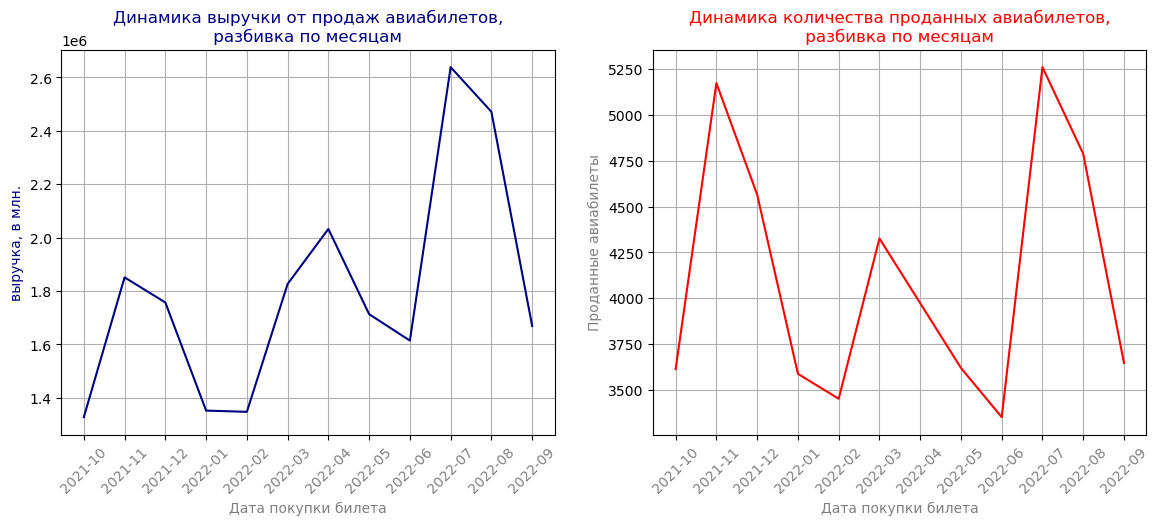

In [31]:
#общая динамика количества продаж
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax=ax.flatten()
ax[0].plot( rev_report['issue_date'],rev_report['sum_revenue_amount'],color='navy')
ax[0].set_ylabel('выручка, в млн.',color='navy')
ax[0].set_title("Динамика выручки от продаж авиабилетов,\n разбивка по месяцам ",color='navy')
ax[0].set_xlabel('Дата покупки билета',color='grey')
ax[0].set_xticks(ticks=range(len(rev_report['issue_date'])))
ax[0].set_xticklabels( labels= rev_report['issue_date'],color='grey',rotation=45)
ax[0].grid(True)
ax[1].plot( rev_report['issue_date'],rev_report['count_revenue_amount'],color='red')
ax[1].set_ylabel('Проданные авиабилеты',color='grey')
ax[1].set_title("Динамика количества проданных авиабилетов,\n разбивка по месяцам ",color='red')
ax[1].set_xlabel('Дата покупки билета',color='grey')
ax[1].grid(True)
ax[1].set_xticks(ticks=range(len(rev_report['issue_date'])))
ax[1].set_xticklabels( labels= rev_report['issue_date'],color='grey',rotation=45)
plt.show()


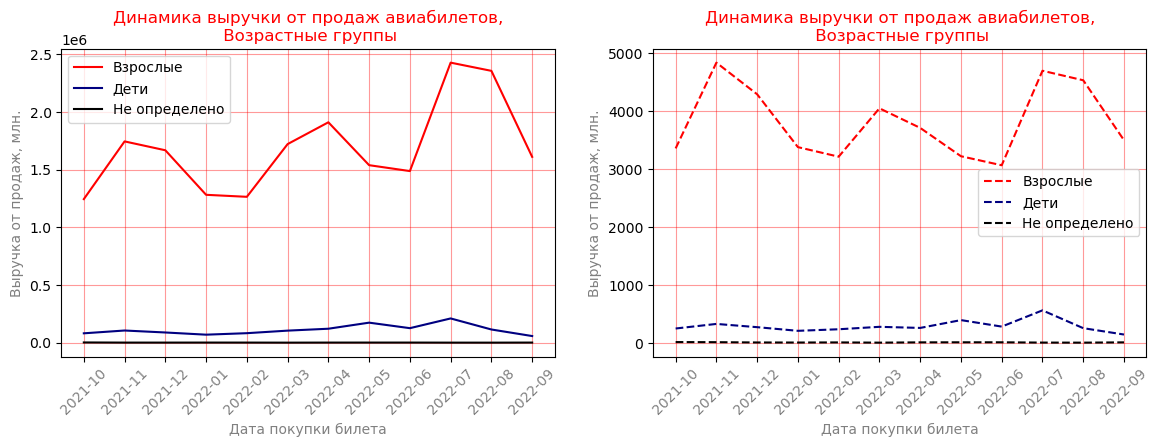

In [275]:
pax_report=pos_rev.pivot_table(index=[data['issue_date'].dt.strftime('%Y-%m'),'pax_type'],
                   aggfunc=['count','sum'],
                   values=['revenue_amount']).reset_index()
pax_report.columns = ['_'.join(col).strip('_') for col in pax_report.columns]
fig,ax=plt.subplots(1,2,figsize=(14,4))
ax=ax.flatten()

ax[0].plot(pax_report[pax_report['pax_type']=='AD']['issue_date'],pax_report.query('pax_type=="AD"')['sum_revenue_amount'],color='red')
ax[0].plot(pax_report[pax_report['pax_type']=='CHD']['issue_date'],pax_report.query('pax_type=="CHD"')['sum_revenue_amount'],color='navy')
ax[0].plot(pax_report[pax_report['pax_type']=='INF']['issue_date'],pax_report.query('pax_type=="INF"')['sum_revenue_amount'],color='black')
#plt.xticks(rotation=45,color='grey')
ax[0].set_title('Динамика выручки от продаж авиабилетов,\n Возрастные группы',color='red')
ax[0].legend(labels=['Взрослые','Дети','Не определено'])
ax[0].set_ylabel('Выручка от продаж, млн.',color='grey')
ax[0].set_xlabel('Дата покупки билета',color='grey')
ax[0].grid(True,color='red',alpha=0.4)
ax[0].set_xticks(ticks=range(len(pax_report[pax_report['pax_type']=='AD'])))
ax[0].set_xticklabels( labels=pax_report[pax_report['pax_type']=='AD']['issue_date'],color='grey',rotation=45)

ax[1].plot(pax_report[pax_report['pax_type']=='AD']['issue_date'],pax_report.query('pax_type=="AD"')['count_revenue_amount'],color='red',linestyle='--')
ax[1].plot(pax_report[pax_report['pax_type']=='AD']['issue_date'],pax_report.query('pax_type=="CHD"')['count_revenue_amount'],color='navy',linestyle='--')
ax[1].plot(pax_report[pax_report['pax_type']=='AD']['issue_date'],pax_report.query('pax_type=="INF"')['count_revenue_amount'],color='black',linestyle='--')
#plt.xticks(rotation=45,color='grey')
ax[1].set_title('Динамика выручки от продаж авиабилетов,\n Возрастные группы',color='red')
ax[1].legend(labels=['Взрослые','Дети','Не определено'])
ax[1].set_ylabel('Выручка от продаж, млн.',color='grey')
ax[1].set_xlabel('Дата покупки билета',color='grey')
ax[1].grid(True,color='red',alpha=0.4)
ax[1].set_xticks(ticks=range(len(pax_report[pax_report['pax_type']=='AD'])))
ax[1].set_xticklabels( labels=pax_report[pax_report['pax_type']=='AD']['issue_date'],color='grey',rotation=45)

plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Можем увидеть, что в основном, большинство билетов приходятся на взрослых. Однако, видим локальный пик продаж детских билетов в июле, что может быть связано с семейными отпусками, совместными путшеешствиями на каникулах

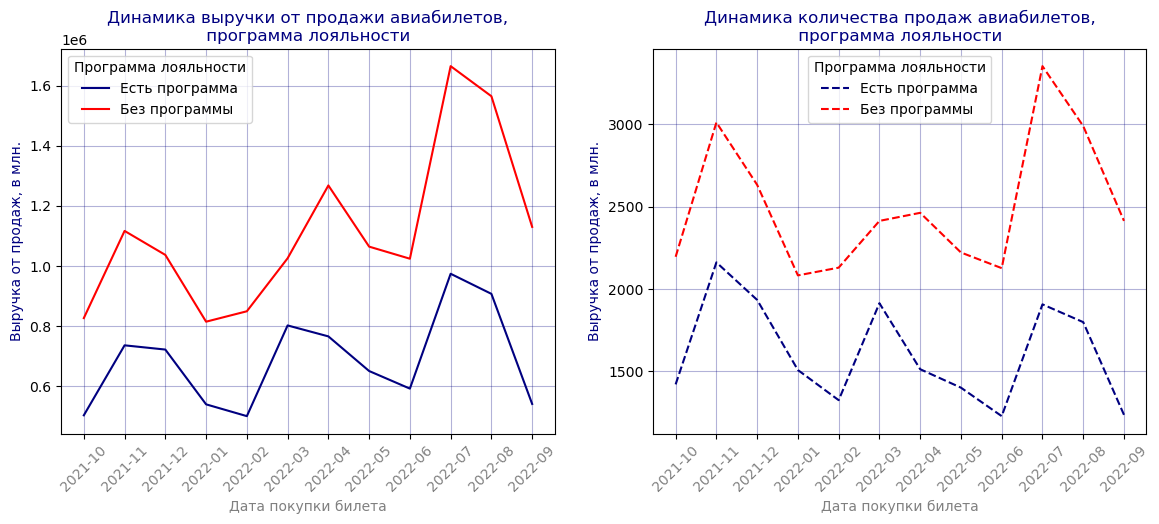

In [34]:
fig,ax=plt.subplots(1,2,figsize=(14,5))
ax=ax.flatten()
ax[0].plot( ffp_report['issue_date'],ffp_report['sum_revenue_amount'],color='navy')
ax[0].set_ylabel('Выручка от продаж, в млн.',color='navy')
#ax[0].set_xticks(rotation=45)
ax[0].plot( missing_ffp_report['issue_date'],missing_ffp_report['sum_revenue_amount'],color='red')
ax[0].set_title("Динамика выручки от продажи авиабилетов,\n программа лояльности ",color='navy')
ax[0].set_xlabel('Дата покупки билета',color='grey')
#ax[0].set_xticks(rotation=45)
ax[0].legend(labels=['Есть программа', 'Без программы'],title='Программа лояльности',loc='best')
ax[0].grid(True,color='navy',alpha=0.3)
ax[0].set_xticks(ticks=range(len(ffp_report['issue_date'])))
ax[0].set_xticklabels( labels= ffp_report['issue_date'],color='grey',rotation=45)

ax[1].plot( ffp_report['issue_date'],ffp_report['count_revenue_amount'],color='navy',linestyle='--')
ax[1].set_ylabel('Выручка от продаж, в млн.',color='navy')
#ax[0].set_xticks(rotation=45)
ax[1].plot( missing_ffp_report['issue_date'],missing_ffp_report['count_revenue_amount'],color='red',linestyle='--')
ax[1].set_title("Динамика количества продаж авиабилетов,\n программа лояльности ",color='navy')
ax[1].set_xlabel('Дата покупки билета',color='grey')
#ax[0].set_xticks(rotation=45)
ax[1].legend(labels=['Есть программа', 'Без программы'],title='Программа лояльности',loc='best')
ax[1].grid(True,color='navy',alpha=0.3)
ax[1].set_xticks(ticks=range(len(ffp_report['issue_date'])))
ax[1].set_xticklabels( labels= ffp_report['issue_date'],color='grey',rotation=45)
plt.show()

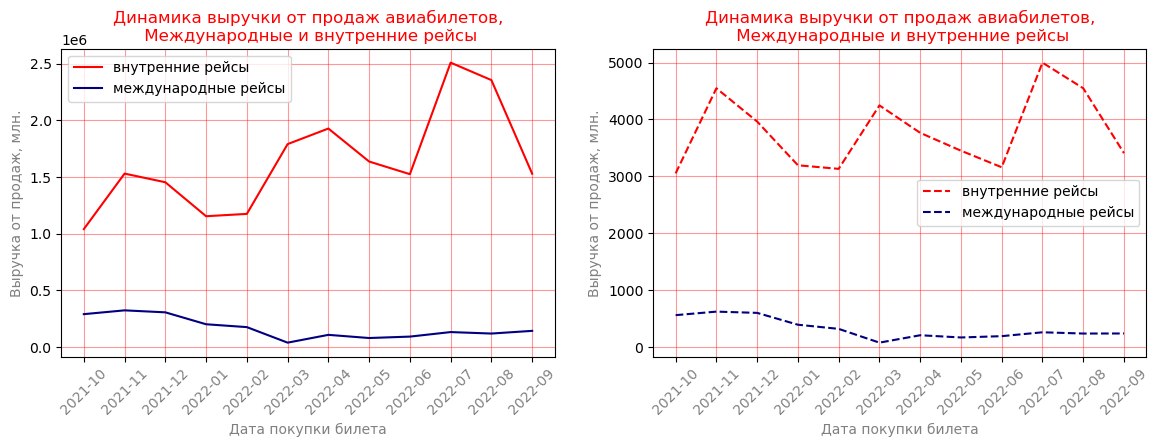

In [35]:
route_report=pos_rev.pivot_table(index=[data['issue_date'].dt.strftime('%Y-%m'),'route_flight_type'],
                   aggfunc=['count','sum'],
                   values=['revenue_amount']).reset_index()
route_report.columns = ['_'.join(col).strip('_') for col in route_report.columns]
fig,ax=plt.subplots(1,2,figsize=(14,4))
ax=ax.flatten()

ax[0].plot(route_report[route_report['route_flight_type']=='ВВЛ']['issue_date'],route_report.query('route_flight_type=="ВВЛ"')['sum_revenue_amount'],color='red')
ax[0].plot(route_report[route_report['route_flight_type']=='МВЛ']['issue_date'],route_report.query('route_flight_type=="МВЛ"')['sum_revenue_amount'],color='navy')
#plt.xticks(rotation=45,color='grey')
ax[0].set_title('Динамика выручки от продаж авиабилетов,\n Международные и внутренние рейсы',color='red')
ax[0].legend(labels=['внутренние рейсы','международные рейсы'])
ax[0].set_ylabel('Выручка от продаж, млн.',color='grey')
ax[0].set_xlabel('Дата покупки билета',color='grey')
ax[0].grid(True,color='red',alpha=0.4)
ax[0].set_xticks(ticks=range(len(route_report[route_report['route_flight_type']=='ВВЛ'])))
ax[0].set_xticklabels( labels= route_report[route_report['route_flight_type']=='ВВЛ']['issue_date'],color='grey',rotation=45)

ax[1].plot(route_report[route_report['route_flight_type']=='ВВЛ']['issue_date'],route_report.query('route_flight_type=="ВВЛ"')['count_revenue_amount'],color='red',linestyle='--')
ax[1].plot(route_report[route_report['route_flight_type']=='МВЛ']['issue_date'],route_report.query('route_flight_type=="МВЛ"')['count_revenue_amount'],color='navy',linestyle='--')
#plt.xticks(rotation=45,color='grey')
ax[1].set_title('Динамика выручки от продаж авиабилетов,\n Международные и внутренние рейсы',color='red')
ax[1].legend(labels=['внутренние рейсы','международные рейсы'])
ax[1].set_ylabel('Выручка от продаж, млн.',color='grey')
ax[1].set_xlabel('Дата покупки билета',color='grey')
ax[1].grid(True,color='red',alpha=0.4)
ax[1].set_xticks(ticks=range(len(route_report[route_report['route_flight_type']=='ВВЛ'])))
ax[1].set_xticklabels( labels= route_report[route_report['route_flight_type']=='МВЛ']['issue_date'],color='grey',rotation=45)

plt.show()

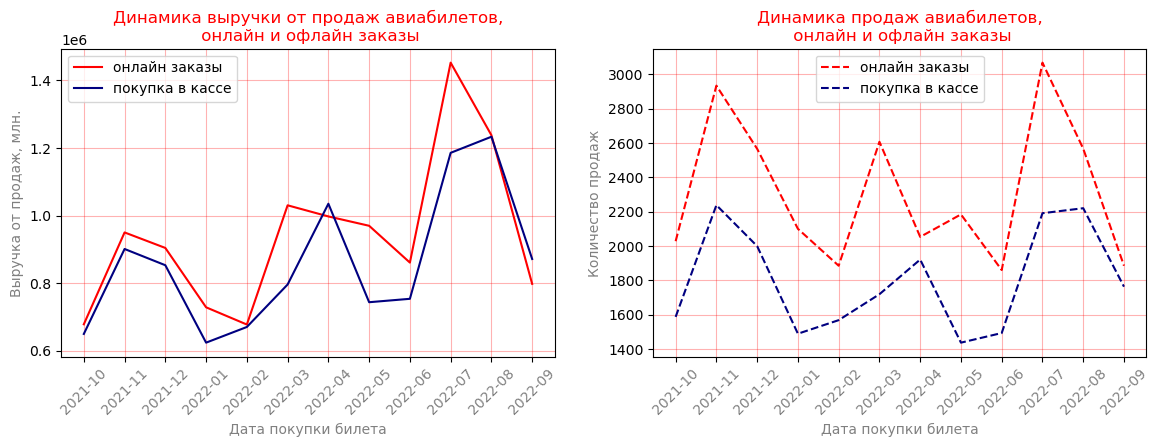

In [36]:
sale_report=pos_rev.pivot_table(index=[data['issue_date'].dt.strftime('%Y-%m'),'sale_type'],
                   aggfunc=['count','sum'],
                   values=['revenue_amount']).reset_index()
sale_report.columns = ['_'.join(col).strip('_') for col in sale_report.columns]
fig,ax=plt.subplots(1,2,figsize=(14,4))
ax=ax.flatten()

ax[0].plot(sale_report[sale_report['sale_type']=='ONLINE']['issue_date'],sale_report.query('sale_type=="ONLINE"')['sum_revenue_amount'],color='red')
ax[0].plot(sale_report[sale_report['sale_type']=='OFFLINE']['issue_date'],sale_report.query('sale_type=="OFFLINE"')['sum_revenue_amount'],color='navy')
#ax[0].xticks(rotation=45,color='grey')
ax[0].set_title('Динамика выручки от продаж авиабилетов,\n онлайн и офлайн заказы',color='red')
ax[0].legend(labels=['онлайн заказы','покупка в кассе'])
ax[0].set_ylabel('Выручка от продаж, млн.',color='grey')
ax[0].set_xlabel('Дата покупки билета',color='grey')
ax[0].grid(True,color='red',alpha=0.3)
ax[0].set_xticks(ticks=range(len(sale_report[sale_report['sale_type']=='ONLINE'])))
ax[0].set_xticklabels( labels= sale_report[sale_report['sale_type']=='ONLINE']['issue_date'],color='grey',rotation=45)

ax[1].plot(sale_report[sale_report['sale_type']=='ONLINE']['issue_date'],sale_report.query('sale_type=="ONLINE"')['count_revenue_amount'],color='red',linestyle='--')
ax[1].plot(sale_report[sale_report['sale_type']=='OFFLINE']['issue_date'],sale_report.query('sale_type=="OFFLINE"')['count_revenue_amount'],color='navy',linestyle='--')
#ax[0].xticks(rotation=45,color='grey')
ax[1].set_title('Динамика продаж авиабилетов,\n онлайн и офлайн заказы',color='red')
ax[1].legend(labels=['онлайн заказы','покупка в кассе'])
ax[1].set_ylabel('Количество продаж',color='grey')
ax[1].set_xlabel('Дата покупки билета',color='grey')
ax[1].grid(True,color='red',alpha=0.3)
ax[1].set_xticks(ticks=range(len(sale_report[sale_report['sale_type']=='ONLINE'])))
ax[1].set_xticklabels( labels= sale_report[sale_report['sale_type']=='ONLINE']['issue_date'],color='grey',rotation=45)

plt.show()

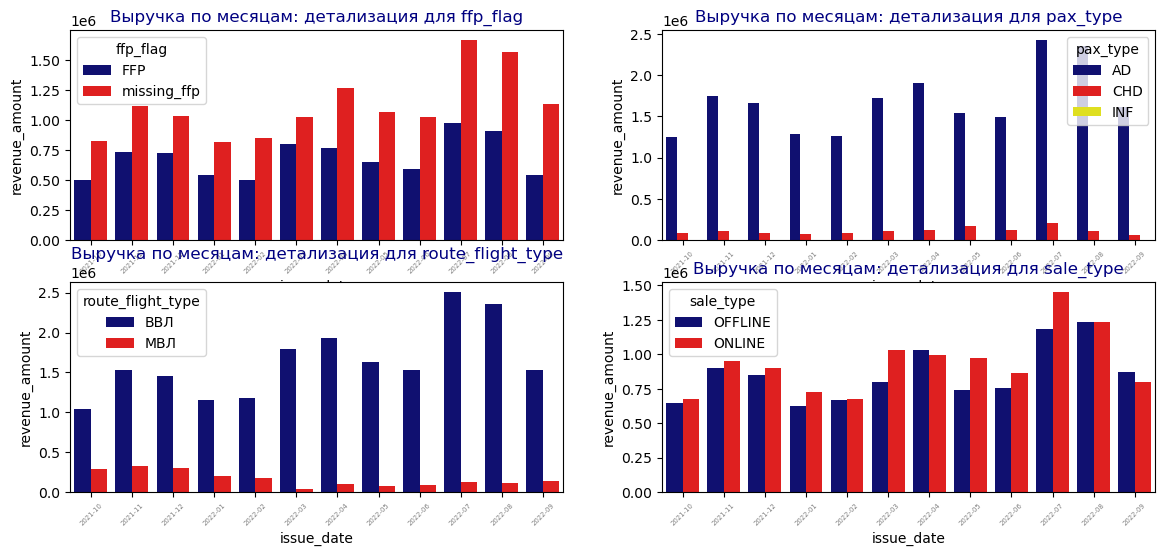

In [37]:
columns_types=['ffp_flag','pax_type','route_flight_type','sale_type']
fig,ax=plt.subplots(2,2,figsize=(14,6))
ax=ax.flatten()
for i,el in enumerate(columns_types):
    report_local=pos_rev.pivot_table(index=[pos_rev['issue_date'].dt.strftime('%Y-%m'),el],
                                     aggfunc='sum',
                                     values='revenue_amount').reset_index()
    ax[i].set_title(f"Выручка по месяцам: детализация для {el}",color='navy')
    ax[i].set_xlabel('месяцы')
    ax[i].set_ylabel('выручка')
    ax[i].set_xticks(ticks=range(12))
    ax[i].set_xticklabels( labels= report_local['issue_date'].unique(),color='grey',rotation=45)
    ax[i].tick_params(axis='x', 
               labelsize=5)
    sns.barplot(data=report_local,x='issue_date',y='revenue_amount',ax=ax[i],hue=el,palette=['navy','red','yellow'])
plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b> ВЫВОДЫ:<b>

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">На представленных графиках была проиллюстрирована дианмика продаж и выручки от продаж авиабилетов. Детализируя вывод графиков по наличию льготной программы, направлению рейса, наличия скидки на авибилет и факта онлайн/офлайн покупки, можно прийти к следующим выводам:

1.<span style="color: navy; padding: 2px 6px; border-radius: 3px;"> Общая динамика выручки и продаж авиабилетов не имеет четковыраженного тренда на уменьшение или увеличение. С другой стороны, мы можем видеть сезонные пики роста продаж и роста выручки в ноябре 2021 года - может быть связано с окончанием коронавирусного локдауна, снятием ограничений на прививание для полетов, черной пятницей и покупкой билетов к новогодним отпускам. Апрель 2022 года явлет собой второй пик активности - многие граждане могли покинуть страну из-за начала СВО, а также, купить билеты для летнего отдыха. Июль 2022 года - третий пик - сезон отпусков, когда многие граждане хотят покинуть свой город и посетить курорты. Максимальная выручка была достигнута в июле 2022 года и составила 2.7 миллиона рублей

2.<span style="color: navy; padding: 2px 6px; border-radius: 3px;"> Детализируя динамику выручки и продаж по наличию программы лояльности, можно заметить, что пики продаж и выручки для тех, кто не использует программу, совпадают с общими пиками. Однако, для пользователей программы лоляльности наблюдается локальный пик продаж в марте 2022 года - компания могла предложить допольнительную скидку или акцию для пользователей программы в этот период. Также, в ноябре 2021 года наблюдается большой прирост покупки билетов, но небольшой (относительно летнего пика) прирост выручки. Что также может сигнализировать о наличии скидок на авиабилеты в ноябре. В 2022 году доля покупок по программе лояльности снижается
<span style="color: navy; padding: 2px 6px; border-radius: 3px;">

3.<span style="color: navy; padding: 2px 6px; border-radius: 3px;"> Анализируя продажу билетов на внутренние и внешние рейсы, можно увидеть спад в выручке и количестве проданных билетов на международных направлениях после 2022 года. Данный спад обсуловлен ограничениями на международные перелеты над Европой для российских авиалиний

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b>Исследуйте выручку, примите решение об исключении выбросов для дальнейшего исследования, руководствуясь минимизацией потерь в данных.<b>

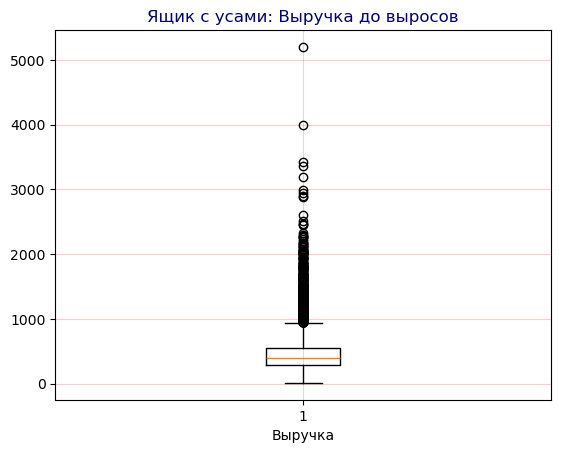

In [40]:
plt.boxplot(pos_rev['revenue_amount'])
plt.title('Ящик с усами: Выручка до выросов', color='navy')
plt.grid(True,color='red',alpha=0.2)
plt.xlabel('Выручка')
plt.show()

In [41]:
median_rev=pos_rev['revenue_amount'].median()
median_rev

400.0

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Мединное значение выручки - 400 рублей, ящик с усами показал большое количество выбросов "сверху" - то есть авиабилеты кратно дороже.  Если обрезать все эти выбросы по границам размаха усов, потеря данных станет ощутимой. Способ 3 сигм возможен при условии нормального распределния. Проверим оба варианта:

In [43]:
#Метод межкварительного размаха
desc_rev=pos_rev['revenue_amount'].describe()
d_25=desc_rev['25%']
d_75=desc_rev['75%']
iqr=d_75-d_25
l_b=desc_rev['25%']-1.5*iqr
u_b=desc_rev['75%']+1.5*iqr
len(pos_rev[(pos_rev['revenue_amount']>u_b)|(pos_rev['revenue_amount']<l_b)])

987

In [44]:
#Метод трех сигм
z_scores = np.abs(st.zscore(pos_rev['revenue_amount']))
sigma_u=np.mean(pos_rev['revenue_amount']) +3*np.std(pos_rev['revenue_amount'])
sigma_l=np.mean(pos_rev['revenue_amount'])-3*np.std(pos_rev['revenue_amount'])
outliers_z =pos_rev[z_scores > 3]
print(f"Z-score метод (>3 стандартных отклонений)")
print(f"  Выбросов: {len(outliers_z)} из {len(pos_rev)} ({(len(outliers_z)/len(pos_rev))*100:.2f}%)")


Z-score метод (>3 стандартных отклонений)
  Выбросов: 464 из 49362 (0.94%)


In [45]:
st.jarque_bera(pos_rev['revenue_amount'])
#Отвергаем гипотезу о нормальном распределении 

SignificanceResult(statistic=545774.9281562493, pvalue=0.0)

Вывод: очистим данные через границы усов

In [47]:
#Очищаем данные от выбросов
pos_rev_cleaned=pos_rev[(pos_rev['revenue_amount']>l_b)&(pos_rev['revenue_amount']<u_b)]
pos_rev_cleaned=pos_rev_cleaned.reset_index(drop=True)

In [48]:
print( "{:.2%}".format(len(pos_rev_cleaned)/len(pos_rev)), 'данных удалось сохранить')

97.89% данных удалось сохранить


In [49]:
len(pos_rev_cleaned)

48320

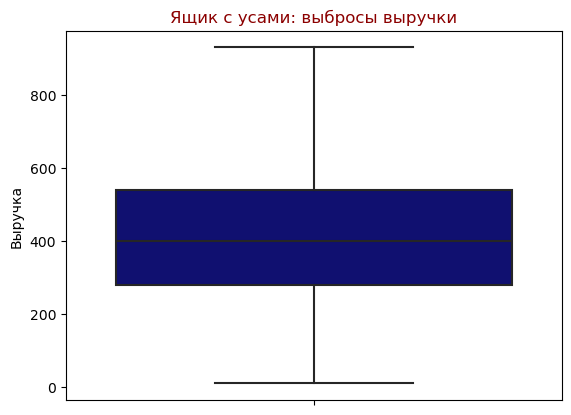

In [50]:
sns.boxplot(data=pos_rev_cleaned,y='revenue_amount',color='navy')
plt.title('Ящик с усами: выбросы выручки',color='darkred')
plt.ylabel('Выручка')
plt.show()

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


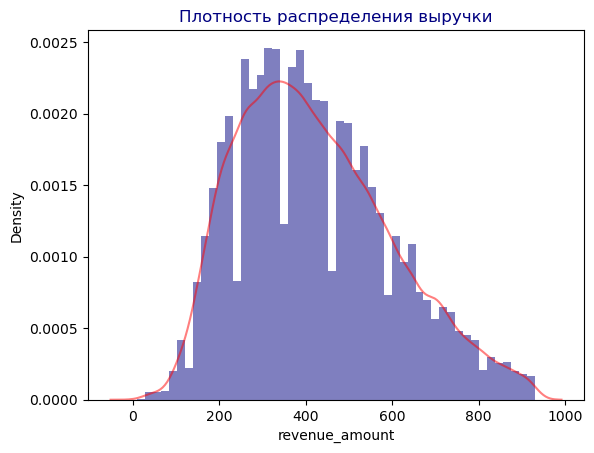

In [51]:
plt.hist(pos_rev_cleaned['revenue_amount'],bins=50,alpha=0.5,density=True,color='navy')
sns.kdeplot(pos_rev_cleaned['revenue_amount'],color='red',alpha=0.5)
plt.title('Плотность распределения выручки',color='navy')
plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b> Сезонность продаж <b>

In [53]:
def seasons(col):
    if col in [1,2,12]:
        return('winter')
    if col in [3,4,5]:
        return('spring')
    if col in [6,7,8]:
        return('summer')
    if col in [9,10,11]:
        return('autumn')

In [54]:
pos_rev_cleaned.loc[:,'season']=pos_rev_cleaned['issue_date'].dt.month.apply(seasons)

In [55]:
#Нет незаполненных сезонов
pos_rev_cleaned['season'].isnull().sum()

0

In [56]:
pos_rev_cleaned.loc[:,'month']=pos_rev_cleaned['issue_date'].dt.month.astype('str')

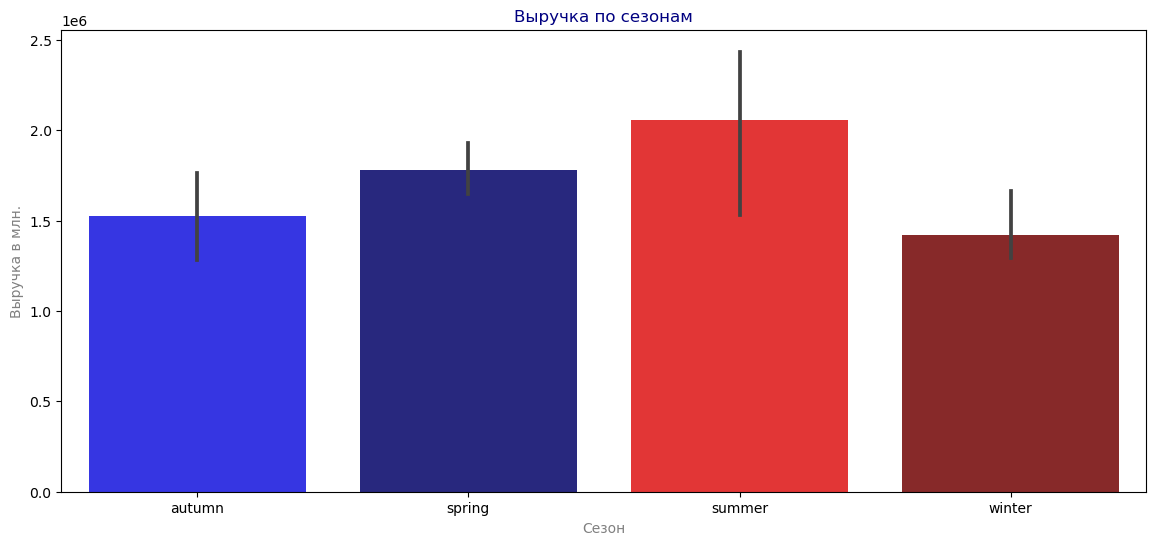

In [57]:
fig,ax=plt.subplots(figsize=(14,6))
seasons_bar=pos_rev_cleaned.groupby(['season','month'])['revenue_amount'].sum().reset_index()
sns.barplot(data=seasons_bar,x='season',y='revenue_amount',palette=['Blue','navy','red','darkred'],alpha=0.9)
plt.title('Выручка по сезонам',color='navy')
plt.xlabel('Сезон',color='grey')
plt.ylabel('Выручка в млн.',color='grey')
plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Наблюдаем большие доверительные интервалы для сезонов - значит внутри каждого присутствует разброс по выручке

In [59]:
season_rev=pos_rev_cleaned.pivot_table(index='season',
                           aggfunc=['count','sum','mean'],
                           values='revenue_amount').reset_index()
season_rev

,season,count,sum,mean
,,revenue_amount,revenue_amount,revenue_amount
0,autumn,12235,4583270,374.603188
1,spring,11715,5336440,455.521980
2,summer,12918,6176460,478.128193
3,winter,11452,4263530,372.295669


In [60]:
autumn=pos_rev_cleaned[pos_rev_cleaned['season']=='autumn']['revenue_amount']
winter=pos_rev_cleaned[pos_rev_cleaned['season']=='winter']['revenue_amount']


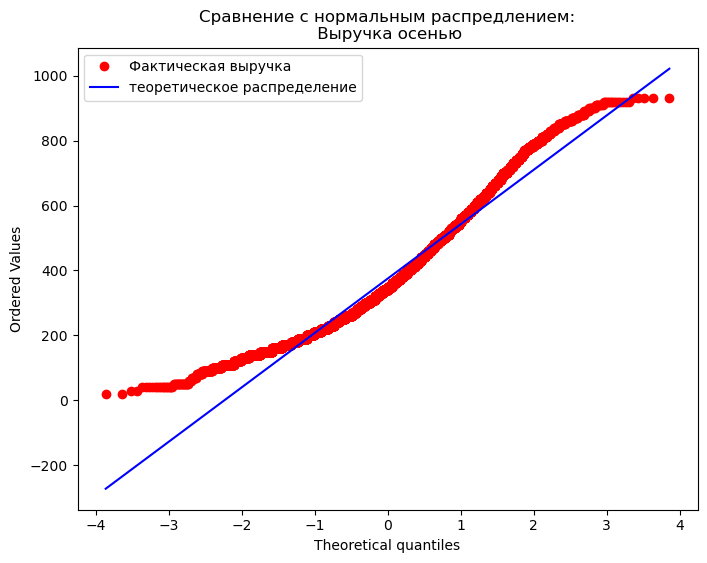

In [61]:
fig, ax = plt.subplots(figsize=(8, 6))
st.probplot(autumn,dist = 'norm', plot = ax)
ax.get_lines()[0].set_color('red')
ax.get_lines()[1].set_color('blue')
plt.title('Сравнение с нормальным распредлением:\n Выручка осенью')
plt.legend(labels=['Фактическая выручка', 'теоретическое распределение'])
plt.show()

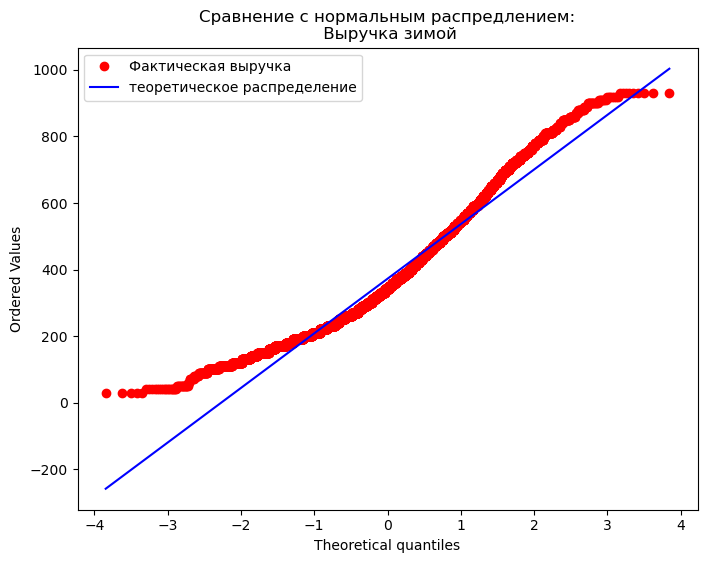

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
st.probplot(winter,dist = 'norm', plot = ax)
ax.get_lines()[0].set_color('red')
ax.get_lines()[1].set_color('blue')
plt.title('Сравнение с нормальным распредлением:\n Выручка зимой')
plt.legend(labels=['Фактическая выручка', 'теоретическое распределение'])
plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Видим отклонения от нормального распрделения - необходимо очистить от выбросов для корректной работы t_test

In [64]:
#Длина каждой из выборок
print(len(autumn),len(winter))

12235 11452


In [65]:
#Отличие в размере выборок
"{:2%}".format((len(autumn)-len(winter))/len(autumn))

'6.399673%'

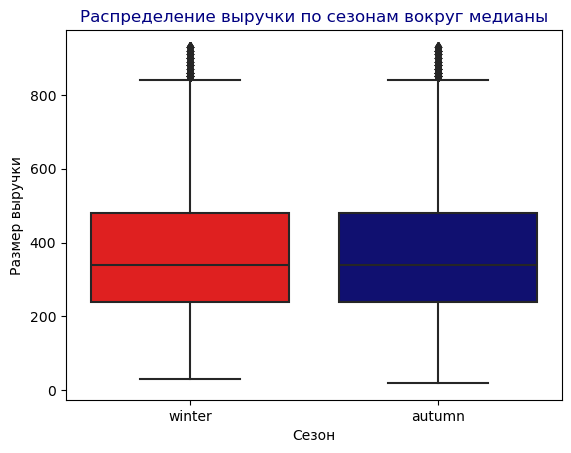

In [66]:
sns.boxplot(data=pos_rev_cleaned,
            x=pos_rev_cleaned[pos_rev_cleaned['season'].isin(['autumn','winter'])]['season'],
            y='revenue_amount',palette=['red','navy'])
plt.title('Распределение выручки по сезонам вокруг медианы',color='navy')
plt.xlabel('Сезон')
plt.ylabel('Размер выручки')
plt.show()

In [67]:
# Очистим выбросы по границам усов:
def boarders(col):
    l_25=col.describe()['25%']
    u_75=col.describe()['75%']
    iqr=u_75-l_25
    l_b=l_25-1.5*iqr
    u_b=u_75+1.5*iqr
    return(l_b,u_b)

In [68]:
autumn=autumn[(autumn>boarders(autumn)[0])&(autumn<boarders(autumn)[1])]
winter=winter[(winter>boarders(winter)[0])&(winter<boarders(winter)[1])]

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b>Проверка гипотезы о равенстве среднего чека в осенний и зимний период:<b>

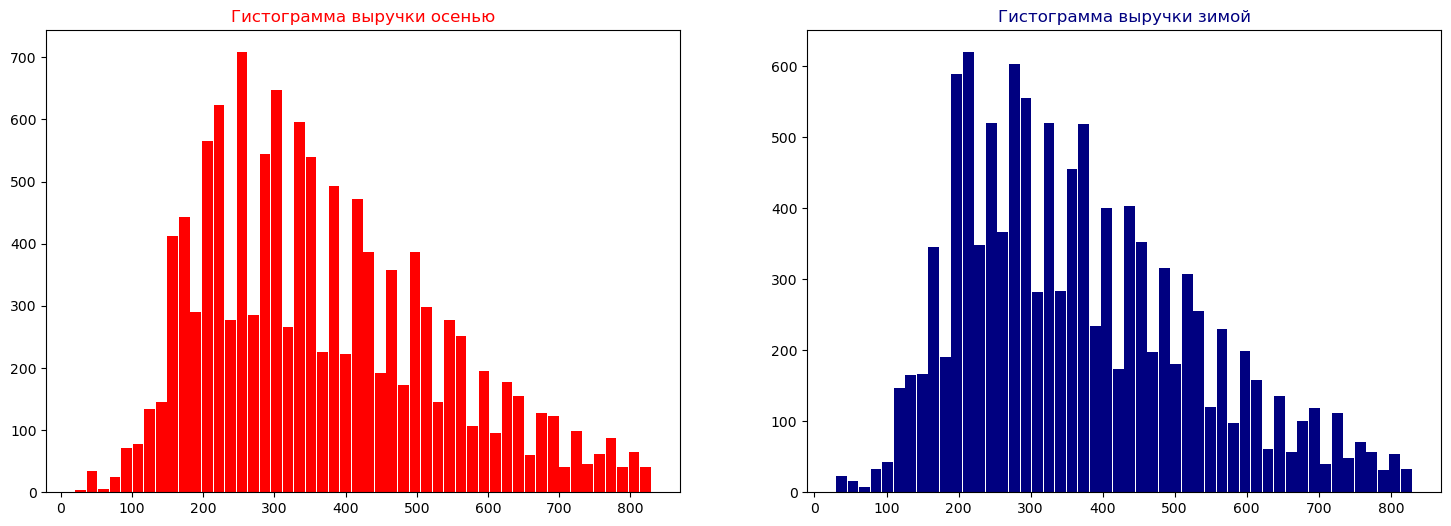

In [70]:
fig,ax= plt.subplots(1,2,figsize=(18,6))
ax=ax.flatten()

ax[0].hist(autumn,width=15,bins=50,color='red')
ax[1].hist(winter,width=15,bins=50,color='navy')
ax[0].set_title('Гистограмма выручки осенью', color='red')
ax[1].set_title('Гистограмма выручки зимой', color='navy')
plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Видим визуально не схожий паттерн, проверим с помощью стат.теста:

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">H0 : нет стат. различий в среднем чеке зимой и летом

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">H1 : существуют статистически значимые различия в среднем чеке зимой и осенью

In [73]:
st.ttest_ind(autumn,winter)

TtestResult(statistic=0.653141613812935, pvalue=0.5136713927482649, df=23440.0)

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Принимаем нулевую гипотезу : нет стат. различий в среднем размере среднего чека зимой и осенью

In [75]:
#Средние выручки
season_rev.iloc[[0,3],-1]

0    374.603188
3    372.295669
Name: (mean, revenue_amount), dtype: float64

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Действительно, различия в средней выручки осенью и зимой практически не отличаются

In [77]:
pos_rev_cleaned.iloc[:,[-8,-1]].groupby('month').sum().reset_index()

,month,revenue_amount
0,1,1303150
1,10,1279930
2,11,1765060
3,12,1666010
4,2,1294370
5,3,1758080
6,4,1930440
7,5,1647920
8,6,1530140
9,7,2434800


<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b>Клиенты покупают билеты в разное время. Кто-то покупает билеты заранее, другие - в последний момент. Проверьте гипотезу о том, что выручка от продажи билетов для этих двух групп клиентов отличается. Предварительно разбейте клиентов минимум на три группы.<b>

In [79]:
# время исполнения билета
pos_rev_cleaned.loc[:,'delta_flight']=pos_rev_cleaned['flight_date_loc']-pos_rev_cleaned['issue_date']

In [80]:
#Формируем границы для группировки клиентов по их поведению в покупках
#Категоризацию осуществим по квантилям 25% и 75%. Сформируем 3 группы
delta_l=pos_rev_cleaned.loc[:,'delta_flight'].describe()['25%']
delta_u=pos_rev_cleaned.loc[:,'delta_flight'].describe()['75%']
print(f"границы в днях до экспирации билета: от {delta_l}, до {delta_u}")

границы в днях до экспирации билета: от 3 days 00:00:00, до 25 days 00:00:00


In [81]:
#Создаем функцию для разделения клиентов по выбранным группировкам: ранние пташки покупают заранее, думспендеры - в последний момент. 
#Остальные - не выделяющееся поведение
def delta_sep(col):
    if col<delta_l:
        return('doomspender') 
    if delta_l<=col<=delta_u:
        return('normal')
    if col>delta_u:
        return('earlybird')

In [82]:
pos_rev_cleaned.loc[:,'buyers']=pos_rev_cleaned['delta_flight'].apply(delta_sep)

In [83]:
doomspenders=pos_rev_cleaned[pos_rev_cleaned['buyers']=='doomspender']['revenue_amount']
earlybirds=pos_rev_cleaned[pos_rev_cleaned['buyers']=='earlybird']['revenue_amount']
normal=pos_rev_cleaned[pos_rev_cleaned['buyers']=='normal']['revenue_amount']

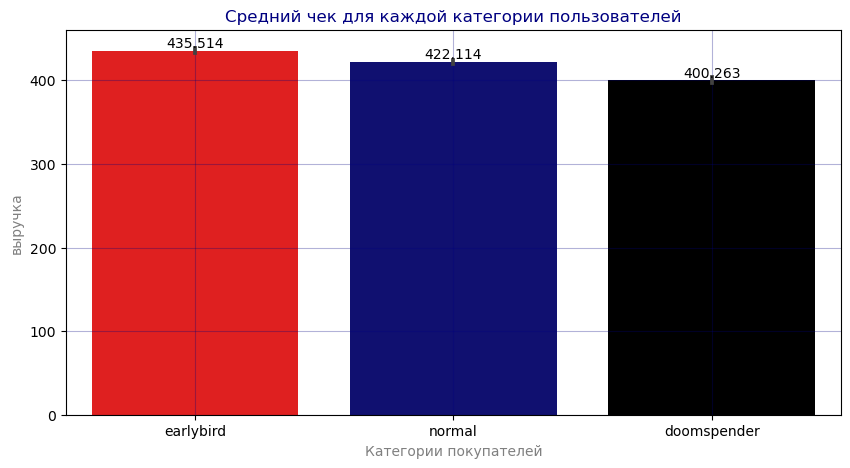

In [84]:
fig,ax=plt.subplots(figsize=(10,5))
sns.barplot(data=pos_rev_cleaned,x='buyers', y= 'revenue_amount',palette=['red','navy','black'])
plt.grid(True, alpha=0.3, color='navy')
plt.title('Средний чек для каждой категории пользователей', color='navy')
plt.xlabel('Категории покупателей',color='grey')
plt.ylabel('выручка',color='grey')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

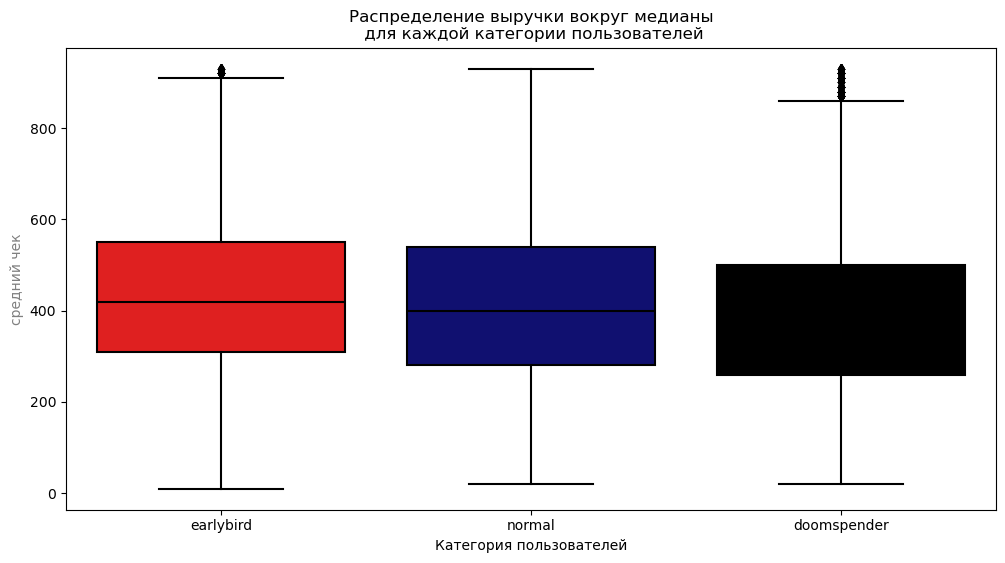

In [85]:
plt.figure(figsize=(12,6))
sns.boxplot(data=pos_rev_cleaned,
            x='buyers', y ='revenue_amount',palette=['red','navy','black'])
plt.xlabel('Категория пользователей')
plt.ylabel('средний чек',color='grey')
plt.title('Распределение выручки вокруг медианы\n для каждой категории пользователей')
plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Сравним с нормальным распределнием каждую категорию пользователей:

In [87]:
#H0: выручка категории пользователей распределена нормально
#H1 : выручка категории не распределена нормально
def checker(col):
    alpha=0.05
    if st.jarque_bera(col)[1]>0.05:
        return('Выручка распределена нормально: H0')
    else:
        return('Выручка не распределена нормально : H1')
    

In [88]:
print(f"""earlybirds:{checker(earlybirds)}\nnormal:{checker(normal)}\ndoomspenders:{checker(doomspenders)}""")

earlybirds:Выручка не распределена нормально : H1
normal:Выручка не распределена нормально : H1
doomspenders:Выручка не распределена нормально : H1


 <span style="color: navy; padding: 2px 6px; border-radius: 3px;">Избавимся от выбросов с помощью границ усов, т.к 3 сигмы требуют нормальности распредления

In [90]:
#Очистка от выбросов
earlybirds=earlybirds[(earlybirds>boarders(earlybirds)[0])&(earlybirds<boarders(earlybirds)[1])]
normal=normal[(normal>boarders(normal)[0])&(normal<boarders(normal)[1])]
doomspenders=doomspenders[(doomspenders>boarders(doomspenders)[0])&(doomspenders<boarders(doomspenders)[1])]

In [91]:
#Проверка гипотез о равенстве выручек по катгеориям. H0 - выручки равны, H1: между выручками есть статистичеси значимая разница , уровень значимости (5%)
from itertools import combinations
categories=[doomspenders,normal,earlybirds]
categories_n=['doomspenders','normal','earlybirds']
combi_2 = list(combinations(categories, 2))
combi_2_n=list(combinations(categories_n, 2))
for i,el in zip(combi_2,combi_2_n):
     if st.ttest_ind(i[0],i[1])[1]>0.05:
        print(f"""Пара{el}:p_val - {st.ttest_ind(i[0],i[1])[1]} Принимаем H0 - выручки равны""")
     else:
        print(f"""Пара{el}: p_val - {st.ttest_ind(i[0],i[1])[1]} Отвергаем H0 - выручки не равны""")

Пара('doomspenders', 'normal'): p_val - 1.3479613881105895e-39 Отвергаем H0 - выручки не равны
Пара('doomspenders', 'earlybirds'): p_val - 7.285632705313692e-65 Отвергаем H0 - выручки не равны
Пара('normal', 'earlybirds'): p_val - 4.266133631724872e-10 Отвергаем H0 - выручки не равны


<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Таким образом, для всех сочетаний покупателей (по их поведению касетльно покупки билета) - выручки не равны. Удивительно, но выручка от "ранних пташек" оказывается самой высокой. Проверим их направления полетов 

In [93]:
pd.crosstab(pos_rev_cleaned['buyers'],pos_rev_cleaned['route_flight_type'])

route_flight_type,ВВЛ,МВЛ
buyers,,
doomspender,8306,582
earlybird,11176,568
normal,25076,2612


In [94]:
pos_rev_cleaned.pivot_table(index=['buyers','route_flight_type'],
                            aggfunc=['sum', 'mean'],
                            values='revenue_amount')

sum           mean
                              revenue_amount revenue_amount
buyers      route_flight_type                              
doomspender ВВЛ                      3281820     395.114375
            МВЛ                       275720     473.745704
earlybird   ВВЛ                      4847380     433.731210
            МВЛ                       267300     470.598592
normal      ВВЛ                     10412110     415.222125
            МВЛ                      1275370     488.273354

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Можем заметить, что цена билетов ВВЛ "В последний момент" - ниже. Возможно, это обсуловлено акциями и горящими билетами. Если не боитесь не улететь - покупайте билеты за пару дней до полета. Касаемо международных направлений, выгодно покупать их заранее, в крайнем случае - также за несколько дней до полета

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b>Определите топ-10 популярных направлений перелета (город-город) отдельно для ВМЛ и МВЛ. Изучите выручку для этих направлений. Для этого добавьте в датасет сведения о городах, используя данные из датасета:<b>

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Подключим внешний датасает, создадим столбцы для городов и заполним пропуски:

In [98]:
column_names = ['Airport Name', 'Location', 'Country', 'IATA_Code', 'ICAO_Code', 'Latitude', 'Longitude', 'Altitude', 'Timezone', 'DST', 'Timezone Region', 'Type', 'Source']
data_2.loc[len(data_2)]=data_2.columns.tolist()

In [99]:
data_2=data_2.iloc[:,1:]

In [100]:
data_2.columns=column_names

In [101]:
pos_rev_cleaned=pos_rev_cleaned.merge(data_2[['Location','IATA_Code']],left_on='orig_city_code',right_on='IATA_Code',how='left').iloc[:,:-1]

In [102]:
pos_rev_cleaned.columns=['issue_date', 'flight_date_loc', 'pax_type', 'revenue_amount',
        'orig_city_code', 'dest_city_code', 'route_flight_type', 'ffp_flag',
        'sale_type', 'season', 'month', 'delta_flight', 'buyers', 
        'city_from']

In [103]:
pos_rev_cleaned=pos_rev_cleaned.merge(data_2[['Location','IATA_Code']],left_on='dest_city_code',right_on='IATA_Code',how='left').iloc[:,:-1]

In [104]:
pos_rev_cleaned.columns=['issue_date', 'flight_date_loc', 'pax_type', 'revenue_amount',
                         'orig_city_code', 'dest_city_code', 'route_flight_type', 'ffp_flag',
        'sale_type', 'season', 'month', 'delta_flight', 'buyers', 'city_from',
        'city_to',]

In [105]:
#Заполним недостающие города - "из"
pos_rev_cleaned[pos_rev_cleaned['city_from'].isna()]['orig_city_code'].unique()

array(['MOW', 'PAR', 'BAK', 'ROM', 'SEL', 'BER', 'GRV', 'NQZ', 'OHH',
       'TOX', 'MIL', 'TYO', 'LON'], dtype=object)

In [106]:
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='MOW','city_from']='Moscow'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='PAR','city_from']='Paris'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='BAK','city_from']='Baku'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='ROM','city_from']='Rome'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='SEL','city_from']='Seul'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='BER','city_from']='Berlin'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='GRV','city_from']='Grozny'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='NQZ','city_from']='Astana'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='OHH','city_from']='Oha'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='PAR','city_from']='Paris'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='TOX','city_from']='Tobolsk'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='MIL','city_from']='Milan'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='TYO','city_from']='Tokio'
pos_rev_cleaned.loc[pos_rev_cleaned['orig_city_code']=='LON','city_from']='London'

In [107]:
#Все заолнили
pos_rev_cleaned[pos_rev_cleaned['city_from'].isna()]['orig_city_code'].unique()

array([], dtype=object)

In [108]:
#Заполним недостающие города - "в"
pos_rev_cleaned[pos_rev_cleaned['city_to'].isna()]['orig_city_code'].unique()

array(['KGD', 'VOZ', 'KZN', 'UUD', 'TAS', 'OMS', 'OVB', 'OGZ', 'AER',
       'EGO', 'KRR', 'SVX', 'KUF', 'NUX', 'BOJ', 'KJA', 'AAQ', 'TOF',
       'LPK', 'AYT', 'HRG', 'LED', 'UFA', 'VAR', 'GDZ', 'SIP', 'ROV',
       'MMK', 'KIV', 'PAR', 'BTK', 'KVK', 'PEE', 'IKT', 'RTW', 'NOZ',
       'MCX', 'GOJ', 'NJC', 'MQF', 'SSH', 'BQS', 'CEK', 'PEZ', 'ULY',
       'MUC', 'NSK', 'VOG', 'KEJ', 'YKS', 'ROM', 'ALA', 'MRV', 'HTA',
       'STW', 'ASF', 'MSQ', 'RGK', 'ABA', 'BAX', 'LBD', 'HER', 'NCE',
       'LWN', 'MOW', 'KSQ', 'UKK', 'BHK', 'ALC', 'NYM', 'IKU', 'BER',
       'UGC', 'OSS', 'DXB', 'SKD', 'BZK', 'NVI', 'BCN', 'BAK', 'SLY',
       'HAJ', 'PFO', 'PUY', 'TLV', 'NOJ', 'GRV', 'MJZ', 'DOH', 'EVN',
       'VVO', 'NER', 'BAH', 'SKG', 'DUS', 'REN', 'BLQ', 'IST', 'NQZ',
       'ZRH', 'VIE', 'MIL', 'SKX', 'CGN', 'LCA', 'CRZ', 'NAL', 'SPU',
       'HMA', 'ATH', 'VRN', 'RHO', 'NBC', 'CMN', 'DLM'], dtype=object)

In [109]:
airport_code_dict = {
    'KGD': 'Kaliningrad',
    'VOZ': 'Voronezh',
    'KZN': 'Kazan',
    'UUD': 'Ulan-Ude',
    'TAS': 'Tashkent',
    'OMS': 'Omsk',
    'OVB': 'Novosibirsk',
    'OGZ': 'Vladikavkaz',
    'AER': 'Sochi',
    'EGO': 'Belgorod',
    'KRR': 'Krasnodar',
    'SVX': 'Yekaterinburg',
    'KUF': 'Samara',
    'NUX': 'Novy Urengoy',
    'BOJ': 'Burgas',
    'KJA': 'Krasnoyarsk',
    'AAQ': 'Anapa',
    'TOF': 'Tomsk',
    'LPK': 'Lipetsk',
    'AYT': 'Antalya',
    'HRG': 'Hurghada',
    'LED': 'Saint Petersburg',
    'UFA': 'Ufa',
    'VAR': 'Varna',
    'GDZ': 'Gelendzhik',
    'SIP': 'Simferopol',
    'ROV': 'Rostov-on-Don',
    'MMK': 'Murmansk',
    'KIV': 'Chisinau',
    'PAR': 'Paris',
    'BTK': 'Bratsk',
    'KVK': 'Kirovsk',
    'PEE': 'Perm',
    'IKT': 'Irkutsk',
    'RTW': 'Saratov',
    'NOZ': 'Novokuznetsk',
    'MCX': 'Makhachkala',
    'GOJ': 'Nizhny Novgorod',
    'NJC': 'Nizhnevartovsk',
    'MQF': 'Magnitogorsk',
    'SSH': 'Sharm El Sheikh',
    'BQS': 'Blagoveshchensk',
    'CEK': 'Chelyabinsk',
    'PEZ': 'Penza',
    'ULY': 'Ulyanovsk',
    'MUC': 'Munich',
    'NSK': 'Norilsk',
    'VOG': 'Volgograd',
    'KEJ': 'Kemerovo',
    'YKS': 'Yakutsk',
    'ROM': 'Rome',
    'ALA': 'Almaty',
    'MRV': 'Mineralnye Vody',
    'HTA': 'Chita',
    'STW': 'Stavropol',
    'ASF': 'Astrakhan',
    'MSQ': 'Minsk',
    'RGK': 'Gorno-Altaysk',
    'ABA': 'Abakan',
    'BAX': 'Barnaul',
    'LBD': 'Khujand',
    'HER': 'Heraklion',
    'NCE': 'Nice',
    'LWN': 'Gyumri',
    'MOW': 'Moscow',
    'KSQ': 'Karshi',
    'UKK': 'Ust-Kamenogorsk',
    'BHK': 'Bukhara',
    'ALC': 'Alicante',
    'NYM': 'Nadym',
    'IKU': 'Tamchy',
    'BER': 'Berlin',
    'UGC': 'Urgench',
    'OSS': 'Osh',
    'DXB': 'Dubai',
    'SKD': 'Samarkand',
    'BZK': 'Bryansk',
    'NVI': 'Navoi',
    'BCN': 'Barcelona',
    'BAK': 'Baku',
    'SLY': 'Salekhard',
    'HAJ': 'Hannover',
    'PFO': 'Paphos',
    'PUY': 'Pula',
    'TLV': 'Tel Aviv',
    'NOJ': 'Noyabrsk',
    'GRV': 'Grozny',
    'MJZ': 'Mirny',
    'DOH': 'Doha',
    'EVN': 'Yerevan',
    'VVO': 'Vladivostok',
    'NER': 'Neryungri',
    'BAH': 'Manama',
    'SKG': 'Thessaloniki',
    'DUS': 'Dusseldorf',
    'REN': 'Orenburg',
    'BLQ': 'Bologna',
    'IST': 'Istanbul',
    'NQZ': 'Nur-Sultan',
    'ZRH': 'Zurich',
    'VIE': 'Vienna',
    'MIL': 'Milan',
    'SKX': 'Saransk',
    'CGN': 'Cologne',
    'LCA': 'Larnaca',
    'CRZ': 'Turkmenabat',
    'NAL': 'Nalchik',
    'SPU': 'Split',
    'HMA': 'Khanty-Mansiysk',
    'ATH': 'Athens',
    'VRN': 'Verona',
    'RHO': 'Rhodes',
    'NBC': 'Naberezhnye Chelny',
    'CMN': 'Casablanca',
    'DLM': 'Dalaman',
    'MOW': 'Moscow',
    'VVO': 'Vladivostok',
    'OVB': 'Novosibirsk',
    'TOX' : 'Tobolsk',
    'SEL':'Seul',
    'TYO': 'Tokio',
    'LON':'London'
}

In [110]:
pos_rev_cleaned['city_to']=pos_rev_cleaned['city_to'].fillna(pos_rev_cleaned['dest_city_code'].map(airport_code_dict))
pos_rev_cleaned['city_from']=pos_rev_cleaned['city_from'].fillna(pos_rev_cleaned['orig_city_code'].map(airport_code_dict))

In [111]:
pos_rev_cleaned[pos_rev_cleaned['city_to'].isna()]['dest_city_code'].unique()

array([], dtype=object)

In [112]:
cities_total=set(pos_rev_cleaned['city_from'].unique().tolist()+pos_rev_cleaned['city_to'].unique().tolist())

In [113]:
cities_total_dict={}
cities_total_reversed={}
for i,el in enumerate(cities_total):
    cities_total_dict[el]=i
    cities_total_reversed[i]=el

In [114]:
pos_rev_cleaned['city_from_n']=pos_rev_cleaned['city_from'].map(cities_total_dict)
pos_rev_cleaned['city_to_n']=pos_rev_cleaned['city_to'].map(cities_total_dict)

In [115]:
# 1. Берём минимум из двух столбцов
pos_rev_cleaned['destination'] =pos_rev_cleaned[['city_from_n', 'city_to_n']].min(axis=1).astype(str) +'-' + pos_rev_cleaned[['city_from_n', 'city_to_n']].max(axis=1).astype(str)  # 2. Берём максимум из двух столбцов


In [116]:
pos_rev_cleaned[['decoded_1','decoded_2']]=pos_rev_cleaned['destination'].str.split('-',expand=True).astype(int)

In [117]:
pos_rev_cleaned['most_popular']=pos_rev_cleaned['decoded_1'].map(cities_total_reversed)+'-'+pos_rev_cleaned['decoded_2'].map(cities_total_reversed)

In [118]:
#Самые популряные направления - ВВЛ
pos_rev_cleaned['most_popular'].value_counts().head(10).reset_index()

,most_popular,count
0,Sochi-Moscow,2618
1,St. Petersburg-Moscow,2401
2,Novosibirsk-Moscow,1910
3,Kazan-Moscow,1516
4,Ufa-Moscow,1359
5,Sochi-Novosibirsk,1253
6,Samara-Moscow,1182
7,St. Petersburg-Novosibirsk,1143
8,Kaliningrad-Moscow,952
9,Mineralnye Vody-Moscow,949


In [119]:
#Самые популряные направления - МВЛ
pos_rev_cleaned[pos_rev_cleaned['route_flight_type']=='МВЛ']['most_popular'].value_counts().head(10).reset_index()

,most_popular,count
0,Osh-Moscow,286
1,Khudzhand-Moscow,273
2,Novosibirsk-Osh,234
3,Bishkek-Novosibirsk,222
4,Khudzhand-Novosibirsk,205
5,Antalya-Moscow,181
6,Kurgan Tyube-Novosibirsk,98
7,Dushanbe-Novosibirsk,94
8,Hurghada-Moscow,93
9,Sharm El Sheikh-Moscow,92


In [120]:
#Выручка самых популряных направлений
international_flights=pos_rev_cleaned.pivot_table(index=pos_rev_cleaned[pos_rev_cleaned['route_flight_type']=='МВЛ']['most_popular'],
                           aggfunc='sum',
                           values='revenue_amount').reset_index().sort_values(by='revenue_amount',ascending=False).head(10)
inner_flights=pos_rev_cleaned.pivot_table(index=pos_rev_cleaned[pos_rev_cleaned['route_flight_type']=='ВВЛ']['most_popular'],
                           aggfunc='sum',
                           values='revenue_amount').reset_index().sort_values(by='revenue_amount',ascending=False).head(10)

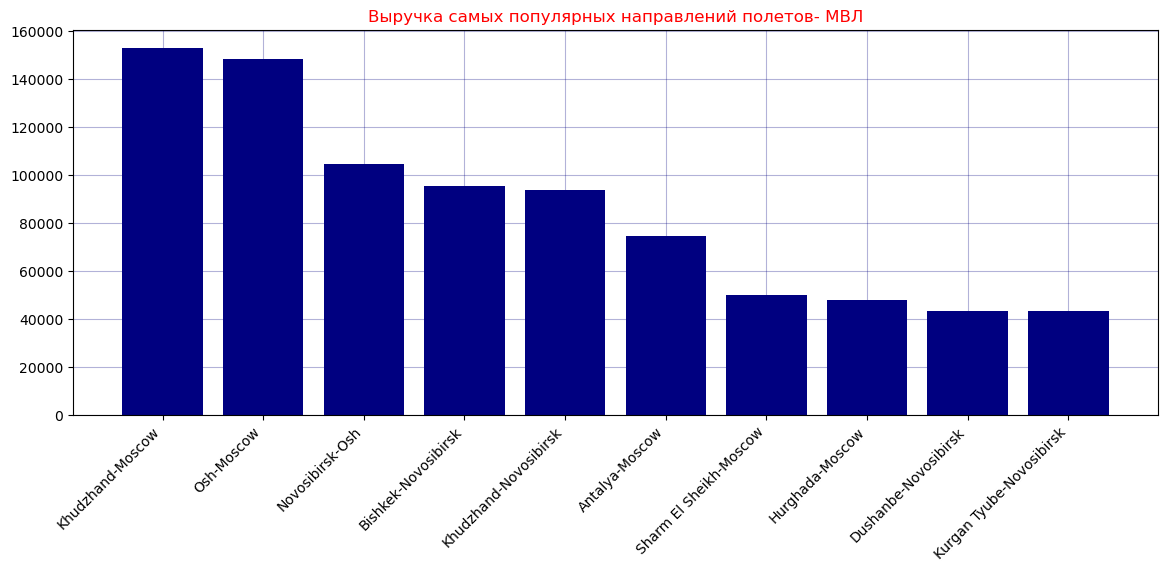

In [121]:
plt.figure(figsize=(14,5))
plt.bar(x=international_flights['most_popular'],height=international_flights['revenue_amount'],color='navy')
plt.xticks(rotation=45,ha='right')
plt.title('Выручка самых популярных направлений полетов- МВЛ',color='red')
plt.grid(True,color='navy',alpha=0.3)
plt.show()

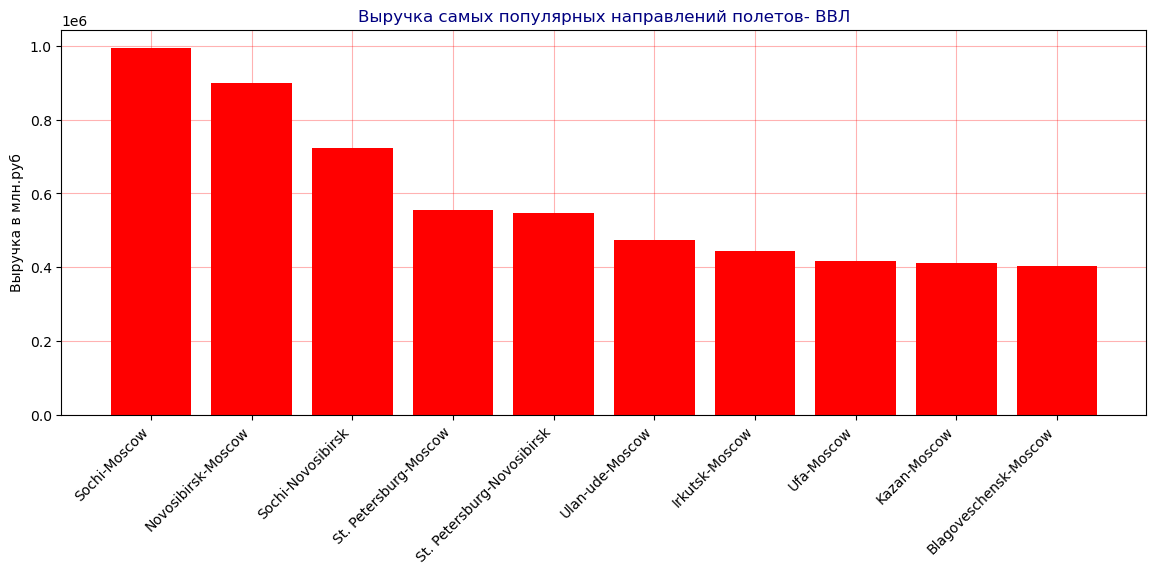

In [122]:
plt.figure(figsize=(14,5))
plt.bar(x=inner_flights['most_popular'],height=inner_flights['revenue_amount'],color='red')
plt.xticks(rotation=45,ha='right')
plt.title('Выручка самых популярных направлений полетов- ВВЛ',color='navy')
plt.ylabel('Выручка в млн.руб')
plt.grid(True,color='red',alpha=0.3)
plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b> ИТОГ <b>

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">На графиках мы видим подборку 10 самых популярных направлений Город-Город без учета направления полета. Я посчитала возможным не учитывать направление полета, так как довольно часто мы можем встретить регулярные рейсы формата город-город, где популярность будет определяться не направленим "из-в", а частота перемещений между этими двумя городами

In [124]:
#Создаем столбец с самыми популярными направлениями С УЧЕТОМ НАПРАВЛЕНИЯ "из-в"
pos_rev_cleaned.loc[:,'most_popular_2']=pos_rev_cleaned['city_from']+'-'+pos_rev_cleaned['city_to']

In [125]:
#ВВЛ
vvl=pos_rev_cleaned[pos_rev_cleaned['route_flight_type']=='ВВЛ'][['most_popular_2','revenue_amount']].groupby('most_popular_2').agg({'revenue_amount':['count','sum','mean']}).reset_index()
vvl.columns=['_'.join(col).strip('_') for col in vvl.columns] 
vvl=vvl.sort_values(by=['revenue_amount_count'],ascending=False).head(10)
vvl

,most_popular_2,revenue_amount_count,revenue_amount_sum,revenue_amount_mean
256,Sochi-Moscow,1326,513970,387.609351
138,Moscow-Sochi,1292,480480,371.888545
260,St. Petersburg-Moscow,1211,280870,231.932287
139,Moscow-St. Petersburg,1190,273720,230.016807
192,Novosibirsk-Moscow,967,460720,476.442606
125,Moscow-Novosibirsk,943,439500,466.065748
52,Kazan-Moscow,759,205230,270.395257
107,Moscow-Kazan,757,204660,270.356671
143,Moscow-Ufa,708,210610,297.471751
209,Novosibirsk-Sochi,667,381530,572.008996


In [126]:
#МВЛ
mvl=pos_rev_cleaned[pos_rev_cleaned['route_flight_type']=='МВЛ'][['most_popular_2','revenue_amount']].groupby('most_popular_2').agg({'revenue_amount':['count','sum','mean']}).reset_index()
mvl.columns=['_'.join(col).strip('_') for col in mvl.columns] #=['cities','count','sum','mean']
mvl=mvl.sort_values(by=['revenue_amount_count'],ascending=False).head(10)
mvl

,most_popular_2,revenue_amount_count,revenue_amount_sum,revenue_amount_mean
167,Moscow-Osh,150,67190,447.933333
100,Khudzhand-Moscow,144,95190,661.041667
224,Osh-Moscow,136,80920,595.000000
157,Moscow-Khudzhand,129,57710,447.364341
198,Novosibirsk-Bishkek,120,46980,391.500000
210,Novosibirsk-Osh,119,47450,398.739496
102,Khudzhand-Novosibirsk,116,57740,497.758621
226,Osh-Novosibirsk,115,56980,495.478261
29,Bishkek-Novosibirsk,102,48300,473.529412
138,Moscow-Antalya,101,38080,377.029703


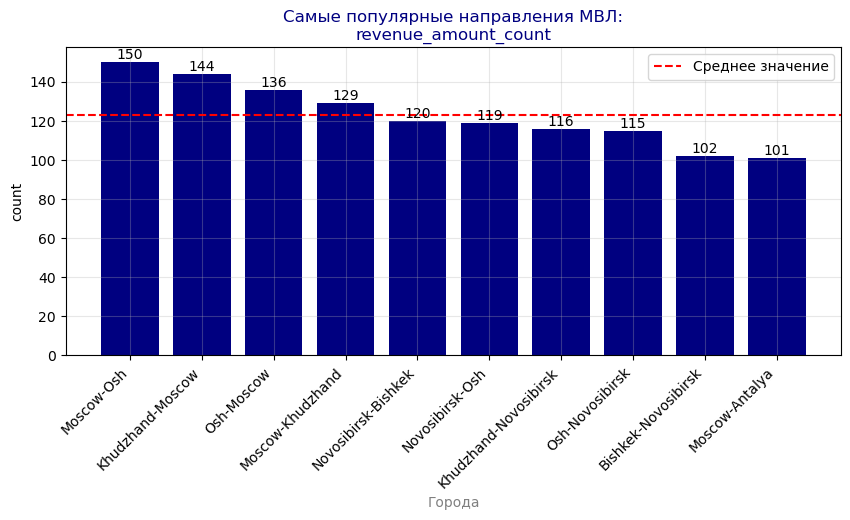

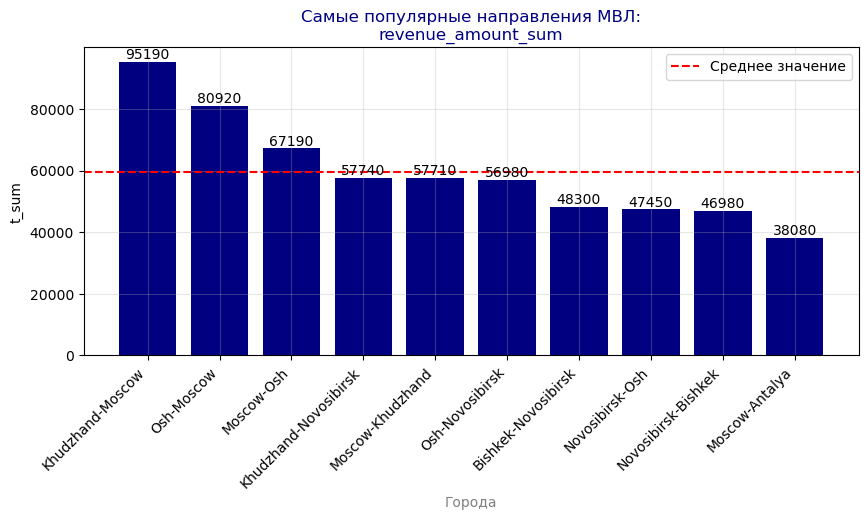

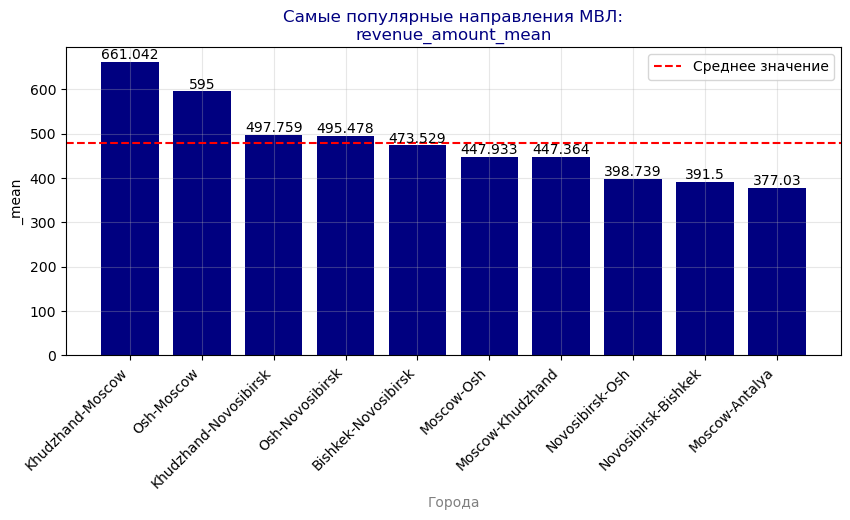

In [127]:
for el in mvl.columns.tolist()[1:]:
    fig,ax=plt.subplots(figsize=(10,4))
    plt.bar(mvl.sort_values(by=el,ascending=False)['most_popular_2'],mvl.sort_values(by=el,ascending=False)[el],color='navy')
    plt.axhline(mvl[el].mean(),linestyle='--',color='red')
    plt.xticks(ha='right',rotation=45)
    plt.legend(labels=['Среднее значение'])
    plt.grid(True,alpha=0.3)
    plt.title(f'Самые популярные направления МВЛ:\n{el}',color='navy')
    plt.xlabel('Города',color='grey')
    plt.ylabel(el[-5:])
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()


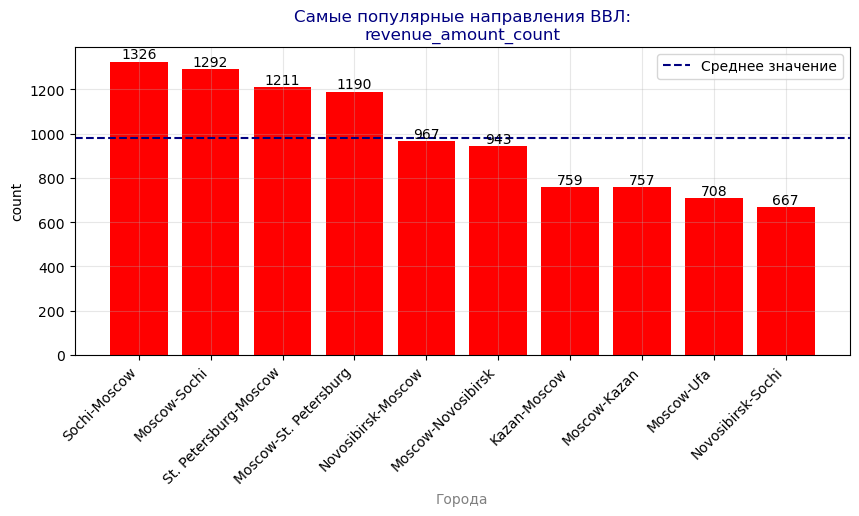

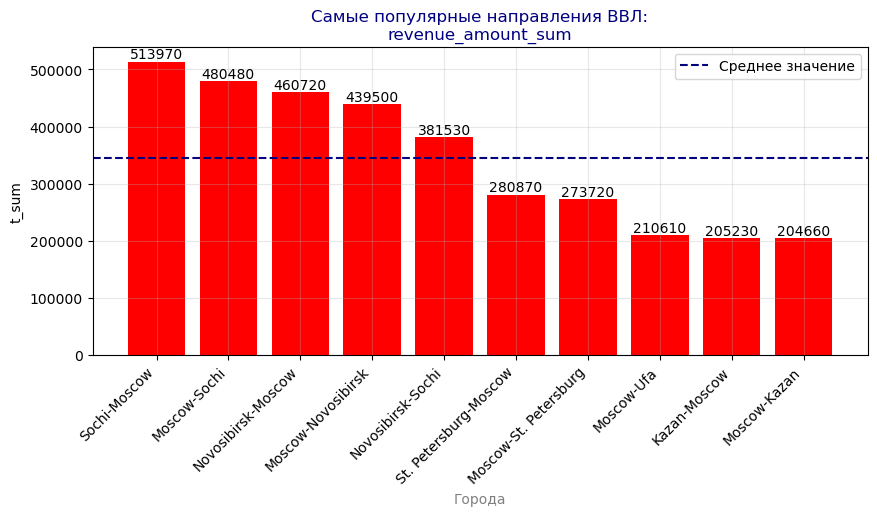

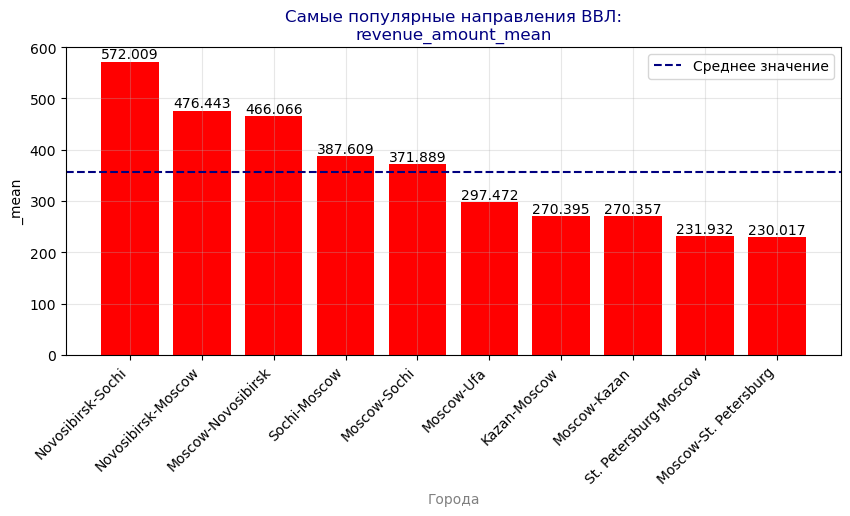

In [128]:
for el in vvl.columns.tolist()[1:]:
    fig,ax=plt.subplots(figsize=(10,4))
    plt.bar(vvl.sort_values(by=el,ascending=False)['most_popular_2'],vvl.sort_values(by=el,ascending=False)[el],color='red')
    plt.axhline(vvl[el].mean(),linestyle='--',color='navy')
    plt.xticks(ha='right',rotation=45)
    plt.legend(labels=['Среднее значение'])
    plt.grid(True,alpha=0.3)
    plt.title(f'Самые популярные направления ВВЛ:\n{el}',color='navy')
    plt.xlabel('Города',color='grey')
    plt.ylabel(el[-5:])
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()


In [129]:
print(f"Средний чек внутренних направлений: {vvl['revenue_amount_mean'].mean()},\nСредний чек международных направлений: {mvl['revenue_amount_mean'].mean()}")

Средний чек внутренних направлений: 357.4188018926642,
Средний чек международных направлений: 478.53748331778144


In [130]:
print(f"Средняя выручка внутренних направлений: {vvl['revenue_amount_sum'].mean()},\nСредняя выручка международных направлений: {mvl['revenue_amount_sum'].mean()}")

Средняя выручка внутренних направлений: 345129.0,
Средняя выручка международных направлений: 59654.0


In [131]:
print(f"Среднее чило полетов внутренних направлений: {vvl['revenue_amount_count'].mean()},\nСреднее чило полетов международных направлений: {mvl['revenue_amount_count'].mean()}")

Среднее чило полетов внутренних направлений: 982.0,
Среднее чило полетов международных направлений: 123.2


<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b> ВЫВОДЫ <b>

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Проанализировав самые популярные направления международной и внутренней авиации, можно прийти к следующим выводам:

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b> ВВЛ <b>
1. ТОП-3 популярных направления ВВЛ: Сочи-Москва, Москва-Сочи, Петербург-Москва
2. Самые дорогие направления: Новосибирск-Сочи, Новосибирск-Москва, Москва-Новосибирск
3. Сочи-Москва и Москва-Сочи лидирует, благодаря большому количеству проданных билетов; Новосибирск-Москва и Москва-Новосибирск - засчет более высокой цены на билеты при мЕньших объемах продаж

 <span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b> МВЛ <b>
1. Москва-Ош : лидирующуу направление
2. Худжанд-Москва самое дорогое направление из популярных. При этом, Москва-Худжанд стоит практически на 30% дешевле. Можно предположить, что через Москву клиенты могут совершать сложные перелеты с пересадками или переезжают в Москву по ВНЖ.
3. В среднем, внутренние направления обходятся дешевле, чем международные: 357 против 478 рублей
4. Выручка внутренних направлений многократно превосходит выручку внешней авиации засчет большого количества перелетов по стране: 982 полета ВВЛ против 123 МВЛ

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b>Определите есть ли зависимость выручки от других признаков. Постройте матрицу корреляций.<b>

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b> Проверим корелляцию выручки и сезонности: <b>

In [135]:
# Создаем срез "Сезон"
rev_season=pos_rev_cleaned[['revenue_amount','season']]

In [136]:
def id_winter(col):
    if col=='winter':
        return (1)
    else:
        return( 0)
def id_spring(col):
    if col=='spring':
        return (1)
    else:
        return( 0) 
def id_summer(col):
    if col=='summer':
        return (1)
    else:
        return( 0)
def id_autumn(col):
    if col=='autumn':
        return (1)
    else:
        return( 0)

In [137]:
#Применим функции к сезонам
rev_season.loc[:,'id_spring']=rev_season['season'].apply(id_spring)
rev_season.loc[:,'id_summer']=rev_season['season'].apply(id_summer)
rev_season.loc[:,'id_autumn']=rev_season['season'].apply(id_autumn)
rev_season.loc[:,'id_winter']=rev_season['season'].apply(id_winter)

C:\Users\HP\AppData\Local\Temp\ipykernel_18280\3777181381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rev_season.loc[:,'id_spring']=rev_season['season'].apply(id_spring)
C:\Users\HP\AppData\Local\Temp\ipykernel_18280\3777181381.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rev_season.loc[:,'id_summer']=rev_season['season'].apply(id_summer)
C:\Users\HP\AppData\Local\Temp\ipykernel_18280\3777181381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


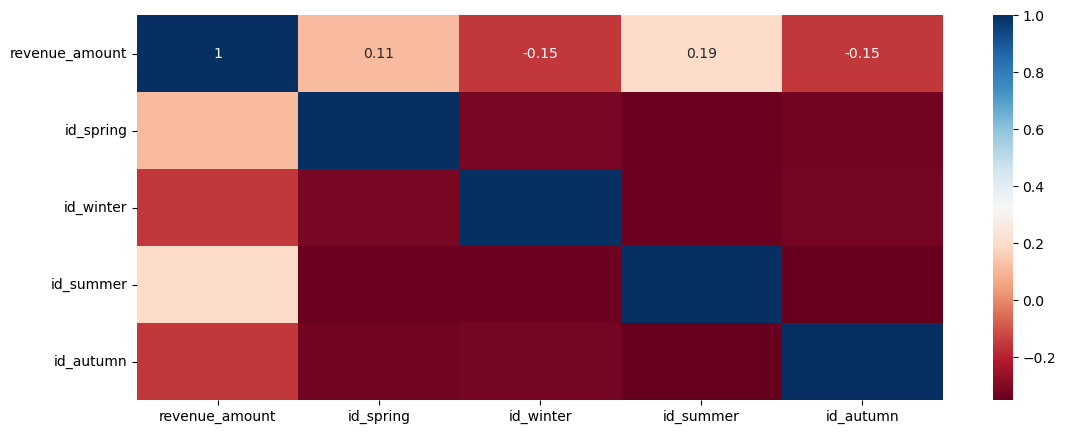

In [138]:
plt.figure(figsize=(13,5))
sns.heatmap(rev_season[['revenue_amount','id_spring','id_winter','id_summer','id_autumn']].corr(),annot=True,cmap='RdBu')
plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Наблюдаем низкую корелляцию выручки со всеми сезонами: Максимальный показатель связи изменения выручки со временем годв наблюдается летом, где коэффициент корреляции r=0.19 , что свидетельствует о слабой связи. Зимой, напротив, мы замечаем слабую отрицательную связь выручки и времени года.
Таким образом, выручка слабо зависит от сезона

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b> Проверим корелляцию выручки и возрастной группы пассажира<b>

In [141]:
rev_age=pos_rev_cleaned[['revenue_amount','pax_type']]

In [142]:
rev_age['pax_type'].unique()

array(['AD', 'CHD', 'INF'], dtype=object)

In [143]:
def ad_id(col):
    if col=='AD':
        return(1)
    else:
        return(0)
def chd_id(col):
    if col=='CHD':
        return(1)
    else:
        return(0)        
def  inf_id(col):
    if col=='INF':
        return(1)
    else:
        return(0)

In [144]:
#Применим функции к возрастам
rev_age.loc[:,'ad_id']=rev_age['pax_type'].apply(ad_id)
rev_age.loc[:,'chd_id']=rev_age['pax_type'].apply(chd_id)
rev_age.loc[:,'inf_id']=rev_age['pax_type'].apply(inf_id)

C:\Users\HP\AppData\Local\Temp\ipykernel_18280\3137986435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rev_age.loc[:,'ad_id']=rev_age['pax_type'].apply(ad_id)
C:\Users\HP\AppData\Local\Temp\ipykernel_18280\3137986435.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rev_age.loc[:,'chd_id']=rev_age['pax_type'].apply(chd_id)
C:\Users\HP\AppData\Local\Temp\ipykernel_18280\3137986435.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

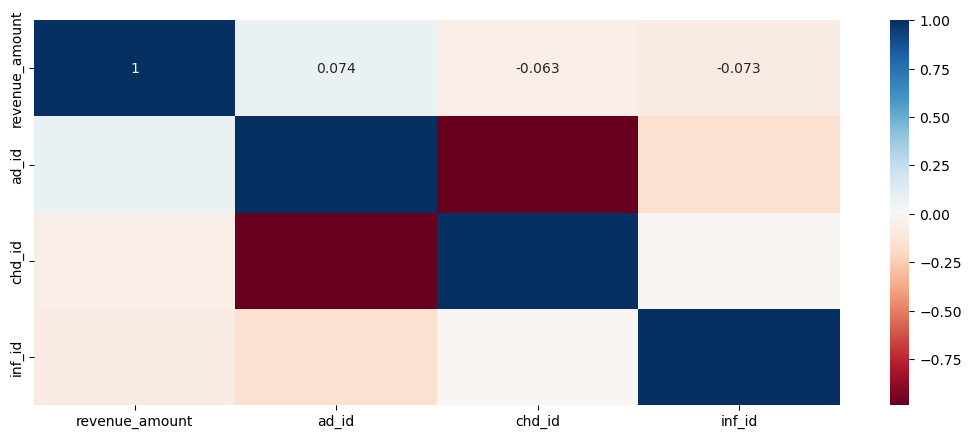

In [145]:
plt.figure(figsize=(13,5))
sns.heatmap(rev_age[['revenue_amount','ad_id','chd_id','inf_id']].corr(),cmap='RdBu',annot=True)
plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Видим крайне низкую корелляцию типа билета по возрастам и выручки. Наибольшим коэфициентом корелляции оказывается 0.074. Этот коэффициент характеризует связь между взрослым билетом и выручкой. Влияние по всем возрастам практически отсутвует

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b> Проверим корелляцию выручки и наличия программы лояльности <b>

In [148]:
rev_ffp=pd.concat([pos_rev_cleaned['revenue_amount'].reset_index(drop=True),pd.get_dummies(pos_rev_cleaned['ffp_flag']).astype(int).reset_index(drop=True)],axis=1)

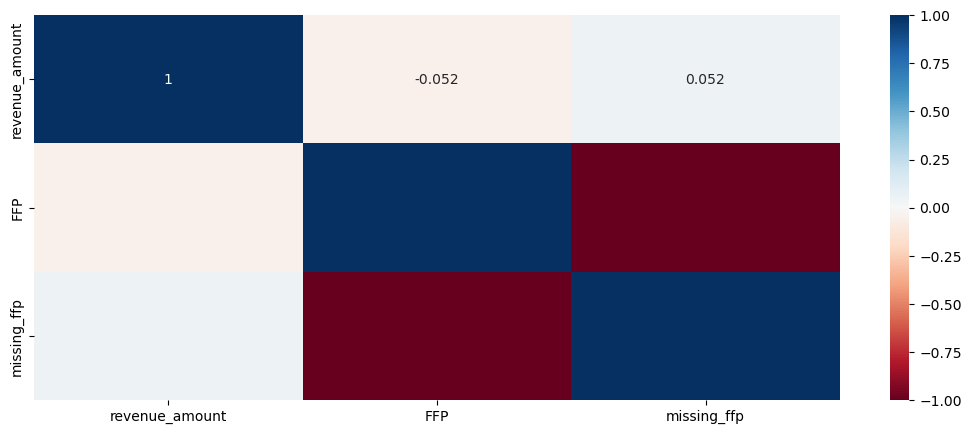

In [149]:
plt.figure(figsize=(13,5))
sns.heatmap(rev_ffp.corr(),cmap='RdBu',annot=True)
plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Анализуя коэффициенты корелляции выручки и наличия/отсутсвия программы лояльности, нельзя заметить взаимосвязь между факторами и результатом. Связь слабая положительная с отсутствием программы и слабая отрицательная, когда программа есть. Влияние по программе лояльности практически отсутствует

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b>Проверим корелляцию выручки и времени покупки билета до вылета (торопыжки, заблаговременная покупка)<b>

In [152]:
#Переведем категориальные данные в бинарный формат
rev_buyers=pd.concat([pos_rev_cleaned['revenue_amount'].reset_index(drop=True),pd.get_dummies(pos_rev_cleaned['buyers']).astype(int).reset_index(drop=True)],axis=1)

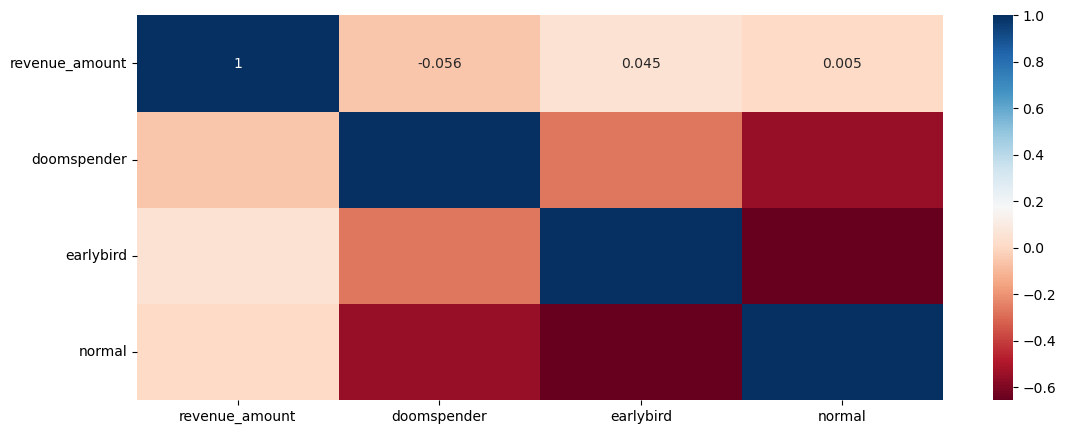

In [153]:
plt.figure(figsize=(13,5))
sns.heatmap(rev_buyers.corr(),cmap='RdBu',annot=True)
plt.show()

<span style="color: navy; padding: 2px 6px; border-radius: 3px;"><b> ВЫВОДЫ <b>

<span style="color: navy; padding: 2px 6px; border-radius: 3px;">Исследовав несколько категориальных признаков: поведение покупателей, категория билета по возрасту, наличию льготной программы, сезон - можно прийти к выводу, что выручка не зависит от большинства обстоятельств. Самое значимое влияние из всех факторов оказывает летний сезон - видим слабую положительную связь.